##  実験目標
- 一局を通して現れる異常な行動を画像ベースで取得する

## 実験手順
- 棋譜から評価値を読み込む -> ok
- 「指し手から次の指し手」までの間隔を画像ベースで把握する -> ok
- 初手から10手をニュートラルの姿勢とし、異常検知をして画像を収集する -> ok
    - 初手から10手の画像とpose抽出画像をそれぞれaddWeightedで重ねる -> ok
    - 2種類の画像を基準に異常な行動画像を抽出
        - 10手で作成した合成画像から外れ値となるしきい値を生成

## モジュールの読み込み


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import imagehash
from PIL import Image

import os
import sys

# 特徴量抽出
from DeNAPose.pose_detector import PoseDetector, draw_person_pose

In [2]:
# データフレームの作成と出力
# 棋譜データの読み込みとデータフレーム作成
# kifデータを合わせる
with open("../data/kif/AbemaTV_Tournament_Final1_analized.kif", encoding="utf-8") as f:
    kif = f.readlines()
shogi_df = pd.DataFrame([int(k.split(" ")[1]) for k in kif if "*##" in k], columns=["score"])
shogi_df['score_label'] = shogi_df["score"].map(lambda x: x//300)
shogi_df["hand_number"] = shogi_df.index

In [ ]:
mean_flag = True
flag_prev, flag_next = True, True
isFujii = True # Falseなら後手
time_idx, hand_idx = 0, 0
threshold = 10
pose_thresh = 5

sampling_frame_rate = 12

pose_frames, hand_labels, times = [], [], []
orig_hash_list, skel_hash_list = [], []

cap = cv2.VideoCapture("/media/nvidia/JetsonTX2SSD240/data/AbemaTV_Tournament_Final1.mp4")
pose_detector = PoseDetector("posenet", "../utils/DeNAPose/models/coco_posenet.npz", device=0)
        
for i in tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//sampling_frame_rate)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, sampling_frame_rate*i)

    frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
    pose_rect = frame[220:510, 1340:1860].copy()
    
    # キャリブレーション用にメモリに確保
    if mean_flag:
        pose_frames.append(pose_rect)
        
    hand_labels.append(hand_idx)

    black_flag_rect = frame[475:630, 35:45].copy()
    white_flag_rect = frame[555:710, 1345:1355].copy()

    # 先手と後手が入れ替わったら(先後判別)
    if (flag_prev ^ flag_next) or i==0:
        b_mean_prev = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_prev = np.mean(white_flag_rect, axis=(0, 1)) 
        flag_prev = flag_next
        #continue

    # 先手もしくは後手が指し手を考慮中の場合
    else:
        b_mean_next = np.mean(black_flag_rect, axis=(0, 1))
        w_mean_next = np.mean(white_flag_rect, axis=(0, 1))

        if flag_prev:
            state = np.mean(b_mean_next - b_mean_prev)
            b_mean_prev = b_mean_next
        else:
            state = np.mean(w_mean_next - w_mean_prev)
            w_mean_prev = w_mean_next 

        if abs(state) > threshold:
            flag_next = not flag_next
            print("{}の指し手までの時間: {}s".format(["先手", "後手"][~flag_prev], (i - time_idx) * sampling_frame_rate//60))
            times.append((i - time_idx) * 0.1)
            time_idx = i
            hand_idx += 1

    # 10手指したらこれまでの画像の平均的な画像をオリジナルとスケルトンの2つで作成
    # 0.1秒ごとの画像が取れているのでそこから10分の1枚をサンプリングして使用
    if (hand_idx == threshold) and mean_flag:
        skel_imgs = []
        
        for idx, img in enumerate(tqdm(pose_frames)):
            if idx==0:
                img_prev_orig = img

                pose_keypoints, scores = pose_detector(img)
                img_prev_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])
                skel_imgs.append(img_prev_skel)
                continue
            else:
                img_next_orig = img

                pose_keypoints, scores = pose_detector(img)
                img_next_skel = draw_person_pose(np.full_like(img, 255), pose_keypoints[np.where(scores > pose_thresh)])
                
                skel_imgs.append(img_next_skel)
                
                if idx==1:
                    img_orig_mean = cv2.addWeighted(img_prev_orig, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_prev_skel, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)
                else:
                    img_orig_mean = cv2.addWeighted(img_orig_mean, 1 - (1/(idx+1)), img_next_orig, 1/(idx+1), 0)
                    img_skel_mean = cv2.addWeighted(img_skel_mean, 1 - (1/(idx+1)), img_next_skel, 1/(idx+1), 0)

        cv2.imwrite("../output/img_orig_mean.png", cv2.cvtColor(img_orig_mean, cv2.COLOR_RGB2BGR))
        cv2.imwrite("../output/img_skel_mean.png", cv2.cvtColor(img_skel_mean, cv2.COLOR_RGB2BGR))
        
        # キャリブレーション
        neutral_orig_hash = imagehash.phash(Image.fromarray(np.uint8(img_orig_mean)))
        neutral_skel_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel_mean)))
        
        for pose_img, skel_img in tqdm(zip(pose_frames, skel_imgs)):
            now_orig_hash = imagehash.phash(Image.fromarray(np.uint8(pose_img)))
            now_skel_hash = imagehash.phash(Image.fromarray(np.uint8(skel_img)))

            orig_hash_list.append(neutral_orig_hash - now_orig_hash)
            skel_hash_list.append(neutral_skel_hash - now_skel_hash)
        
        # スケルトン画像を使ったphashの差分の平均値を基準にする
        abnorm_thresh = np.array(skel_hash_list).mean()
        print("phash thresh: {}".format(abnorm_thresh))
        
        mean_flag = False
        mean_idx = i
        del pose_frames
            

    # 11手目からperceptual hashで差分を比較
    # 10手目までのキャリブレーションとしてヒストグラムを出してみる
    elif (hand_idx >= threshold) :
        #neutral_orig_hash = imagehash.phash(Image.fromarray(np.uint8(img_orig_mean)))
        now_orig_hash = imagehash.phash(Image.fromarray(np.uint8(black_flag_rect if isFujii else white_flag_rect)))

        #neutral_skel_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel_mean)))
        pose_keypoints, scores = pose_detector(pose_rect)
        img_skel = draw_person_pose(np.full_like(pose_rect, 255), pose_keypoints[np.where(scores > 5)])
        now_skel_hash = imagehash.phash(Image.fromarray(np.uint8(img_skel)))
        
        orig_diff_hash = neutral_orig_hash - now_orig_hash
        skel_diff_hash = neutral_skel_hash - now_skel_hash
        
        # 基準値を超えていれば異常行動とみなす
        if skel_diff_hash > abnorm_thresh:
            sup_or_inf = shogi_df.loc[hand_idx]["score_label"]
            
            if sup_or_inf == 0: # 評価値 -300 < x < 300
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_minus_0/original/pose_orig_handnum{}_frame{}.png".format(hand_idx, i),
                            cv2.cvtColor(pose_rect, cv2.COLOR_RGB2BGR))
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_minus_0/skelton/pose_skel_handnum{}_frame{}.png".format(hand_idx, i), 
                            cv2.cvtColor(img_skel, cv2.COLOR_RGB2BGR))
            elif 0 < sup_or_inf < 6: # 評価値 300 < x < 1500
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_{}/original/pose_handnum{}_frame{}.png".format(sup_or_inf,hand_idx, i), 
                            cv2.cvtColor(pose_rect, cv2.COLOR_RGB2BGR))
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_{}/skelton/pose_handnum{}_frame{}.png".format(sup_or_inf,hand_idx, i), 
                            cv2.cvtColor(img_skel, cv2.COLOR_RGB2BGR))
            elif -6 < sup_or_inf < 6: # 評価値 -1500 < x < -300
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/minus_{}/original/pose_handnum{}_frame{}.png".format(abs(sup_or_inf),hand_idx, i), 
                            cv2.cvtColor(pose_rect, cv2.COLOR_RGB2BGR))
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/minus_{}/skelton/pose_handnum{}_frame{}.png".format(abs(sup_or_inf),hand_idx, i), 
                            cv2.cvtColor(img_skel, cv2.COLOR_RGB2BGR))
            elif 6 <= sup_or_inf: # 評価値 1500 <= x
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_inf/original/pose_handnum{}_frame{}.png".format(hand_idx, i), 
                            cv2.cvtColor(pose_rect, cv2.COLOR_RGB2BGR))
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/plus_inf/skelton/pose_handnum{}_frame{}.png".format(hand_idx, i), 
                            cv2.cvtColor(img_skel, cv2.COLOR_RGB2BGR))
            elif sup_or_inf <= -6: # 評価値 x <= -1500
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/minus_inf/original/pose_handnum{}_frame{}.png".format(hand_idx, i), 
                            cv2.cvtColor(pose_rect, cv2.COLOR_RGB2BGR))
                cv2.imwrite("/media/nvidia/JetsonTX2SSD240/data/sup_or_inf/minus_inf/skelton/pose_handnum{}_frame{}.png".format(hand_idx, i), 
                            cv2.cvtColor(img_skel, cv2.COLOR_RGB2BGR))
                
        orig_hash_list.append(orig_diff_hash)
        skel_hash_list.append(skel_diff_hash)
        

# phashデータのデータフレーム作成
extract_df = pd.DataFrame(orig_hash_list, columns=["original_hash"])
extract_df["skelton_hash"] = skel_hash_list
extract_df["hand_number"] = hand_labels

# 結合
df = pd.merge(extract_df, shogi_df, on="hand_number")
df.to_csv("../data/AbemaTV_Tournament_Final1_pose_data_frame{}.csv".format(sampling_frame_rate), index=False)

Loading the model...


先手の指し手までの時間: 2s
後手の指し手までの時間: 2s
先手の指し手までの時間: 3s
後手の指し手までの時間: 1s
先手の指し手までの時間: 2s
後手の指し手までの時間: 2s
先手の指し手までの時間: 4s
後手の指し手までの時間: 1s
先手の指し手までの時間: 2s
後手の指し手までの時間: 3s


/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])


phash thresh: 11.470149253731343
先手の指し手までの時間: 3s
後手の指し手までの時間: 1s
先手の指し手までの時間: 2s
後手の指し手までの時間: 1s
先手の指し手までの時間: 3s
後手の指し手までの時間: 1s
先手の指し手までの時間: 2s
後手の指し手までの時間: 1s
先手の指し手までの時間: 9s
後手の指し手までの時間: 1s
先手の指し手までの時間: 2s
後手の指し手までの時間: 2s
先手の指し手までの時間: 7s
後手の指し手までの時間: 2s
先手の指し手までの時間: 2s
後手の指し手までの時間: 2s
先手の指し手までの時間: 7s
後手の指し手までの時間: 2s
先手の指し手までの時間: 10s
後手の指し手までの時間: 1s
先手の指し手までの時間: 4s
後手の指し手までの時間: 2s
先手の指し手までの時間: 2s
後手の指し手までの時間: 2s
先手の指し手までの時間: 3s
後手の指し手までの時間: 3s
先手の指し手までの時間: 2s
後手の指し手までの時間: 3s
先手の指し手までの時間: 2s
後手の指し手までの時間: 10s
先手の指し手までの時間: 4s
後手の指し手までの時間: 49s
先手の指し手までの時間: 12s
後手の指し手までの時間: 32s
先手の指し手までの時間: 2s
後手の指し手までの時間: 27s
先手の指し手までの時間: 40s
後手の指し手までの時間: 15s
先手の指し手までの時間: 5s


## 統計的に異常を検知するための指標を決定する

In [23]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)//sampling_frame_rate

1032.0

In [24]:
len(orig_hash_list)

1032

In [25]:
len(pose_frames)

1032

In [6]:
len(skel_imgs)

28

In [7]:
len(hand_labels)

1032

In [9]:
extract_df = pd.DataFrame(orig_hash_list, columns=["original_hash"])

In [10]:
extract_df["skelton_hash"] = skel_hash_list

In [12]:
extract_df["hand_number"] = hand_labels

Text(0.5,1,'difference perceptual hash using image original')

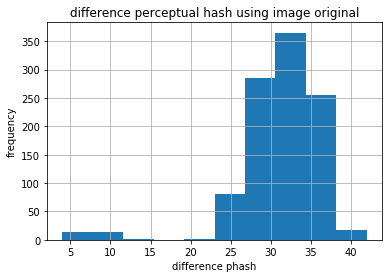

In [13]:
ax = extract_df.original_hash.hist()
ax.set_xlabel("difference phash")
ax.set_ylabel("frequency")
ax.set_title("difference perceptual hash using image original")

In [44]:
mean_idx

27

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 2160x1296 with 0 Axes>

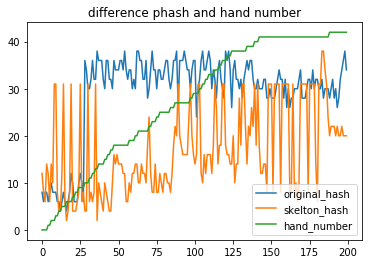

In [42]:
plt.figure(figsize=(30,18))
extract_df[:200].plot()
plt.title("difference phash and hand number")
plt.legend(loc='lower right')#, bbox_to_anchor=(1.0, 0.5))
plt.savefig("difference_phash_and_hand_number.pdf")

In [53]:
# kifデータを合わせる
with open("../data/kif/AbemaTV_Tournament_Final1_analized.kif", encoding="utf-8") as f:
    kif = f.readlines()
shogi_df = pd.DataFrame([int(k.split(" ")[1]) for k in kif if "*##" in k], columns=["score"])
shogi_df['score_label'] = shogi_df["score"].map(lambda x: x//300)
shogi_df["hand_number"] = shogi_df.index

In [54]:
extract_df.head()

,original_hash,skelton_hash,hand_number
0,8,12,0
1,6,8,0
2,8,6,0
3,8,14,0
4,6,12,1


/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


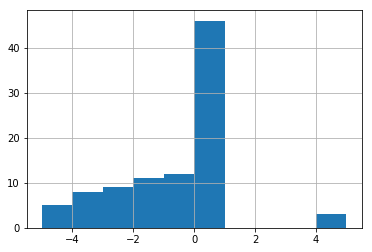

In [55]:
shogi_df[(shogi_df.score_label.apply(lambda x: abs(x))) < 6].score_label.hist()

In [61]:
df = pd.merge(extract_df, shogi_df, on="hand_number")

In [85]:
extract_df[extract_df.hand_number <= 10].describe()

,original_hash,skelton_hash,hand_number
count,31.000000,31.000000,31.000000
mean,10.000000,11.741935,5.064516
std,8.049845,10.079576,3.355945
min,4.000000,2.000000,0.000000
25%,6.000000,4.000000,2.000000
50%,8.000000,8.000000,5.000000
75%,10.000000,13.000000,8.000000
max,36.000000,31.000000,10.000000


/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 2160x1296 with 0 Axes>

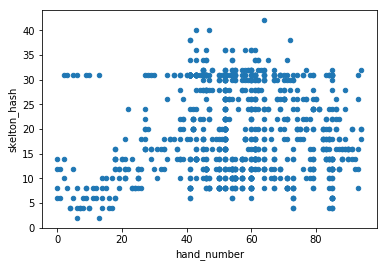

In [80]:
plt.figure(figsize=(30,18))
extract_df.plot(kind="scatter", x="hand_number", y="skelton_hash")

In [82]:
df.to_csv("../data/AbemaTV_Tournament_Final1_pose_data_frame{}.csv".format(sampling_frame_rate), index=False)

In [83]:
df

,original_hash,skelton_hash,hand_number,score,score_label
0,8,12,0,0,0
1,6,8,0,0,0
2,8,6,0,0,0
3,8,14,0,0,0
4,6,12,1,0,0
5,8,6,1,0,0
6,10,14,2,0,0
7,8,10,2,0,0
8,8,31,2,0,0
9,8,31,3,0,0
